## <p style="text-align: center;">Исследование аномалий в multivariate time-series при помощи вариационных автокодировщиков на базе TCN и трансформеров</p>

### План работы: 

1. Построение и обучение вариационного автокодировщика на базе: 
- линейной модели
- модели на базе TCN (Temporal Convolution Network - имплементация из библиотеки [Darts](https://github.com/unit8co/darts#installation-guide))
- транфсорфмеров (из PyTorch)
2. Обучение модеели VAE на fault free (healthy) data. Подбор гиперпараметров.
3. Выявление аномалий и составление датасета для классификации аномалий по маркированному датасету.
4. Подсчет метри Precision и Recall для тестового датасета в задаче классификации аномалий.
5. Выводы, сравнение с бенчмарками.

Данные:
[Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1)

In [1]:
!pip install pyreadr

     |████████████████████████████████| 361 kB 14.6 MB/s 
     |████████████████████████████████| 11.3 MB 55.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


In [1]:
from itertools import chain
from collections import defaultdict
import requests
import pandas as pd
import numpy as np
import pyreadr
import pickle
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import MSELoss
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from scipy.stats import norm
from tqdm.notebook import tqdm 
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
open('tcn_model.py', 'w').write(requests.get('https://raw.githubusercontent.com/AlexShevchuk7/MADE/master/Diploma/tcn_model.py').text)
open('TEP_FaultFree_Training.RData', 'wb').write(requests.get('https://github.com/AlexShevchuk7/MADE/blob/master/Diploma/TEP_FaultFree_Training.RData?raw=true').content)
open('testdata.csv', 'w').write(requests.get('https://github.com/AlexShevchuk7/MADE/blob/master/Diploma/test_dataset.csv?raw=true').text)

19141299

In [3]:
from tcn_model import TCNModel

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
class BaselinePCA():
    
    def spe(self, X, X_pred): 
        return np.sum((X - X_pred) ** 2, axis=1)
   
    def train(self, df_train, plot=False):
        
        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)

        self.m = PCA(n_components=12)

        X_train = scale(df_train)
        X_train_pred = self.m.inverse_transform(self.m.fit_transform(X_train))
        
        if plot:
            fig, ax = plt.subplots()
            xaxis = np.arange(len(self.m.explained_variance_ratio_))
            ax.bar(xaxis, self.m.explained_variance_ratio_)
            ax.plot(xaxis, np.cumsum(self.m.explained_variance_ratio_));
            ax.set_title('PCA - Explained variance');
        
        return self.spe(X_train, X_train_pred)
            
    def test(self, df_test, plot = False):
        
        X_test = np.array((df_test - self.mu_train) / self.std_train)
        X_test_pred = self.m.inverse_transform(self.m.transform(X_test))

        return self.spe(X_test, X_test_pred)

In [5]:
class TSDataset(Dataset):
    def __init__(self, data, window, offset):
        self.data = torch.Tensor(data)
        self.window = window
        self.offset = offset
        self.shape = self.__getshape__()
        self.size = self.__getsize__()
 
    def __getitem__(self, index):
        x = self.data[index : index + self.window]
        return x
 
    def __len__(self):
        return len(self.data) -  self.window 
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [ ]:
class Basic_net(nn.Module):
    def __init__(self, batch, hidden_dim=1024):
        super(Basic_net, self).__init__()
        self.hidden_dim = hidden_dim
        input_dim = batch.shape[1] * batch.shape[2]
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim , hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.model(x)
        return torch.reshape(x, (-1, batch.shape[1], int(self.hidden_dim // 4 / batch.shape[1])))

In [ ]:
class LinearEncoder(nn.Module):
    def __init__(self, input_, latent_dim=16):
        super(LinearEncoder, self).__init__()        
        self.embedding = Basic_net(batch)
        
        self.hidden_dim = input_.shape[1] * input_.shape[2]
        self.mu = nn.Linear(self.hidden_dim, latent_dim)
        self.sigma = nn.Linear(self.hidden_dim, latent_dim)
    
    def forward(self, x):
        embedding = self.embedding(x)
        flat_embedding = torch.flatten(embedding, start_dim=1)
        
        mu = F.relu(self.mu(flat_embedding))
        logsigma = F.relu(self.sigma(flat_embedding))
        
        return mu, logsigma

In [35]:
class TCNEncoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TCNEncoder, self).__init__()
        tcn1 = TCNModel(num_filters=20, input_chunk_length=batch.shape[1], output_chunk_length=batch.shape[1])
        self.tcn_model1 = tcn1._create_model(batch).to(device)
        self.batchnorm1 = nn.BatchNorm1d(batch.shape[1]).to(device)
        self.maxpool1 = nn.MaxPool1d(5, stride=2)
        
        tcn1_out = self.tcn_model1(batch)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2 = TCNModel(num_filters=10, input_chunk_length=maxpool1.shape[1], output_chunk_length=maxpool1.shape[1])
        self.tcn_model2 = tcn2._create_model(maxpool1).to(device)
        tcn2_out = self.tcn_model2(maxpool1)
        
        self.batchnorm2 = nn.BatchNorm1d(maxpool1.shape[1]).to(device)
        self.maxpool2 = nn.MaxPool1d(5, stride=2)
        
        batchnorm2 = self.batchnorm2(tcn2_out)
        maxpool2 = self.maxpool2(batchnorm2)
                
        input_dim = maxpool2.shape[1] * maxpool2.shape[2]
        self.mu = nn.Linear(input_dim, latent_dim)
        self.logvar = nn.Linear(input_dim, latent_dim)
    
    def forward(self, x):
        tcn1_out = self.tcn_model1(x)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2_out = self.tcn_model2(maxpool1)
        batchnorm2 = self.batchnorm2(tcn2_out)
        maxpool2 = self.maxpool2(batchnorm2)

        flat_embedding = torch.flatten(maxpool2, start_dim=1)
        
        mu = F.relu(self.mu(flat_embedding))
        logvar = F.relu(self.logvar(flat_embedding))
        
        return mu, logvar

In [36]:
class TCNDecoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TCNDecoder, self).__init__()
        self.batch_shape = batch.shape
        
        self.linear = nn.Linear(latent_dim, batch.shape[1] * batch.shape[2] // 2)
        self.batchnorm1 = nn.BatchNorm1d(batch.shape[1])
        
        tcn1 = TCNModel(num_filters=10, input_chunk_length=batch.shape[1], output_chunk_length=batch.shape[1])
        self.tcn_model1 = tcn1._create_model(batch[:, :, :batch.shape[2] // 2]).to(device)

        self.upsample = nn.Upsample(batch.shape[2])
        self.batchnorm2 = nn.BatchNorm1d(batch.shape[1])

        tcn2 = TCNModel(num_filters=20, input_chunk_length=batch.shape[1], output_chunk_length=batch.shape[1])
        self.tcn_model2 = tcn2._create_model(batch).to(device)
    
    def forward(self, x):
        x = self.linear(x).reshape(-1, self.batch_shape[1], self.batch_shape[2] // 2)
        x = self.batchnorm1(x)
        x = self.tcn_model1(x)
        x = self.upsample(x)
        x = self.batchnorm2(x)
        x = self.tcn_model2(x)    
        
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, batch_shape, latent_dim):
        super(Decoder, self).__init__()
        self.batch_dim = batch_shape[0]
        self.chunk_length = batch_shape[1]
        self.chunk_size = batch_shape[2]
                
        self.fc1 = nn.Linear(latent_dim, latent_dim * 8)
        self.fc2 = nn.Linear(latent_dim * 8, latent_dim * 16)
        self.fc3 = nn.Linear(latent_dim * 16, latent_dim * 32)
        self.fc4 = nn.Linear(latent_dim * 32, self.chunk_length * self.chunk_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return torch.reshape(x, (-1, self.chunk_length, self.chunk_size))

In [25]:
class TCNEncoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TCNEncoder, self).__init__()
        w = batch.shape[1]
        tcn1 = TCNModel(num_filters=30, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model1 = tcn1._create_model(batch).to(device)
        self.batchnorm1 = nn.BatchNorm1d(w).to(device)
        self.maxpool1 = nn.MaxPool1d(5, stride=2)
        
        tcn1_out = self.tcn_model1(batch)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2 = TCNModel(num_filters=20, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model2 = tcn2._create_model(maxpool1).to(device)
        tcn2_out = self.tcn_model2(maxpool1)
        
        self.batchnorm2 = nn.BatchNorm1d(w).to(device)
        self.maxpool2 = nn.MaxPool1d(5, stride=2)
        
        batchnorm2 = self.batchnorm2(tcn2_out)
        maxpool2 = self.maxpool2(batchnorm2)
        
        tcn3 = TCNModel(num_filters=10, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model3 = tcn3._create_model(maxpool2).to(device)
        tcn3_out = self.tcn_model3(maxpool2)
        
        self.batchnorm3 = nn.BatchNorm1d(w).to(device)
        self.maxpool3 = nn.MaxPool1d(5, stride=3)
        
        batchnorm3 = self.batchnorm3(tcn3_out)
        maxpool3 = self.maxpool3(batchnorm3)
                
        input_dim = w * maxpool3.shape[2]
        self.mu = nn.Linear(input_dim, latent_dim)
        self.logvar = nn.Linear(input_dim, latent_dim)
    
    def forward(self, x):
        tcn1_out = self.tcn_model1(x)
        batch_out1 = self.batchnorm1(tcn1_out)
        maxpool1 = self.maxpool1(batch_out1)
        
        tcn2_out = self.tcn_model2(maxpool1)
        batchnorm2 = self.batchnorm2(tcn2_out)
        maxpool2 = self.maxpool2(batchnorm2)
        
        tcn3_out = self.tcn_model3(maxpool2)
        batchnorm3 = self.batchnorm3(tcn3_out)
        maxpool3 = self.maxpool3(batchnorm3)

        flat_embedding = torch.flatten(maxpool3, start_dim=1)
        
        mu = F.relu(self.mu(flat_embedding))
        logvar = F.relu(self.logvar(flat_embedding))
        
        return mu, logvar

In [26]:
class TCNDecoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TCNDecoder, self).__init__()
        w = batch.shape[1]
        self.batch_shape = batch.shape
        
        self.linear = nn.Linear(latent_dim, w * batch.shape[2] // 4)
        self.batchnorm1 = nn.BatchNorm1d(w)
        
        tcn1 = TCNModel(num_filters=10, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model1 = tcn1._create_model(batch[:, :, :batch.shape[2] // 4]).to(device)

        self.upsample1 = nn.Upsample(batch.shape[2] // 2)
        self.batchnorm2 = nn.BatchNorm1d(w)

        tcn2 = TCNModel(num_filters=20, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model2 = tcn2._create_model(batch[:, :, :batch.shape[2] // 2]).to(device)
        
        self.upsample2 = nn.Upsample(batch.shape[2])
        self.batchnorm3 = nn.BatchNorm1d(w)

        tcn3 = TCNModel(num_filters=30, input_chunk_length=w, output_chunk_length=w)
        self.tcn_model3 = tcn3._create_model(batch).to(device)
    
    def forward(self, x):
        x = self.linear(x).reshape(-1, self.batch_shape[1], self.batch_shape[2] // 4)
        x = self.batchnorm1(x)
        x = self.tcn_model1(x)
        x = self.upsample1(x)
        x = self.batchnorm2(x)
        x = self.tcn_model2(x)
        x = self.upsample2(x)
        x = self.batchnorm3(x)
        x = self.tcn_model3(x)
        
        return x

In [6]:
class TransformEncoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TransformEncoder, self).__init__()
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=52, nhead=4, dim_feedforward=256)
        self.transformer = nn.modules.TransformerEncoder(self.encoder_layer, num_layers=8)
                             
        self.hidden_dim = batch.shape[1] * batch.shape[2]
        self.mu = nn.Linear(self.hidden_dim, latent_dim)
        self.sigma = nn.Linear(self.hidden_dim, latent_dim)
    
    def forward(self, x):
        embedding = self.transformer(x)
        flat_embedding = torch.flatten(embedding, start_dim=1)
        
        mu = F.relu(self.mu(flat_embedding))
        logsigma = F.relu(self.sigma(flat_embedding))
        
        return mu, logsigma, embedding

In [7]:
class TransformDecoder(nn.Module):
    def __init__(self, batch, latent_dim=16):
        super(TransformDecoder, self).__init__()
        
        self.linear = nn.Linear(16, batch.shape[1] * batch.shape[2])
        tdecoderlayer = nn.TransformerDecoderLayer(d_model=52, nhead=4)
        self.decoder = nn.modules.TransformerDecoder(tdecoderlayer, num_layers=8)
    
    def forward(self, x, memory):
        tgt = self.linear(x).reshape(-1, batch.shape[1], batch.shape[2])
        decoded = self.decoder(tgt, memory)
        
        return decoded

In [8]:
class TVAE(nn.Module):
    def __init__(self, encoder, decoder, device=device):
        super(TVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.mu = None
        self.std = None
        
    def sample_z(self, mu, std):
        epsilon = torch.randn(mu.size())
        epsilon = Variable(epsilon, requires_grad=False).type(torch.FloatTensor).to(self.device)
        z = mu + std * epsilon
        return z
    
    def forward(self, x):
        self.mu, logvar, memory = self.encoder(x)
        self.std = torch.exp(0.5 * logvar)
        z = self.sample_z(self.mu.to(self.device), self.std.to(self.device))
        decoder_out = self.decoder(z, memory)
        return decoder_out, self.mu, logvar

In [8]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, device=device):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.mu = None
        self.std = None
        
    def sample_z(self, mu, std):
        epsilon = torch.randn(mu.size())
        epsilon = Variable(epsilon, requires_grad=False).type(torch.FloatTensor).to(self.device)
        z = mu + std * epsilon
        return z
    
    def forward(self, x):
        self.mu, logvar = self.encoder(x)
        self.std = torch.exp(0.5 * logvar)
        z = self.sample_z(self.mu.to(self.device), self.std.to(self.device))
        decoder_out = self.decoder(z)
        return decoder_out, self.mu, logvar

### Считывание обучающих анных. Формирование dataloader

In [9]:
train_data = pyreadr.read_r('TEP_FaultFree_Training.RData')

In [10]:
for items in train_data.items():
    tsdata = items[1]

In [ ]:
tsdata.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [ ]:
tsdata.describe()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,...,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,1.050000e+01,2.505000e+02,2.505000e+02,2.613588e-01,3.663777e+03,4.506046e+03,9.370345e+00,2.690156e+01,4.236419e+01,2.723005e+03,...,5.431755e+01,3.043177e+01,6.324830e+01,2.295485e+01,3.992297e+01,3.807265e+01,4.643742e+01,5.060598e+01,4.194845e+01,1.884376e+01
std,5.766282e+00,1.443373e+02,1.443373e+02,1.495384e-01,4.316941e+01,1.110368e+02,3.646151e-01,2.320034e-01,3.172128e-01,7.599384e+01,...,5.258092e+00,2.048365e+01,7.400080e+00,1.108258e+01,1.293348e+01,2.949138e+00,2.358468e+00,1.759840e+01,1.001227e+01,5.176705e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,-4.735000e-03,3.327400e+03,3.540700e+03,6.639900e+00,2.538600e+01,3.965600e+01,2.413800e+03,...,3.118400e+01,-2.718600e-01,-4.893100e-03,-9.941000e-02,0.000000e+00,2.280100e+01,3.492300e+01,-3.635500e-01,-2.809500e-01,-5.327000e-03
25%,5.750000e+00,1.257500e+02,1.257500e+02,2.183000e-01,3.636500e+03,4.469000e+03,9.264200e+00,2.676000e+01,4.218100e+01,2.697600e+03,...,5.349700e+01,2.228000e+01,6.031400e+01,2.142300e+01,3.831300e+01,3.604900e+01,4.487800e+01,4.547900e+01,4.057500e+01,1.714300e+01
50%,1.050000e+01,2.505000e+02,2.505000e+02,2.511300e-01,3.663300e+03,4.508500e+03,9.355200e+00,2.690100e+01,4.234800e+01,2.705600e+03,...,5.397000e+01,2.521500e+01,6.149900e+01,2.212900e+01,3.996700e+01,3.815000e+01,4.633900e+01,4.806500e+01,4.120600e+01,1.829500e+01
75%,1.525000e+01,3.752500e+02,3.752500e+02,2.832100e-01,3.690200e+03,4.548000e+03,9.456800e+00,2.704300e+01,4.252400e+01,2.715000e+03,...,5.444300e+01,2.879700e+01,6.284100e+01,2.273800e+01,4.150700e+01,3.999100e+01,4.803100e+01,5.188700e+01,4.194900e+01,1.953700e+01
max,2.000000e+01,5.000000e+02,5.000000e+02,1.017500e+00,3.906700e+03,5.175800e+03,1.224000e+01,2.848600e+01,4.465300e+01,3.000500e+03,...,1.000000e+02,1.001900e+02,1.000200e+02,1.001100e+02,9.752800e+01,5.312100e+01,5.998000e+01,1.005200e+02,1.003200e+02,1.000100e+02


In [11]:
scaler = StandardScaler()
minmax = MinMaxScaler()

signal = tsdata.iloc[:, 3:] 
mm_train_signal = minmax.fit_transform(signal)

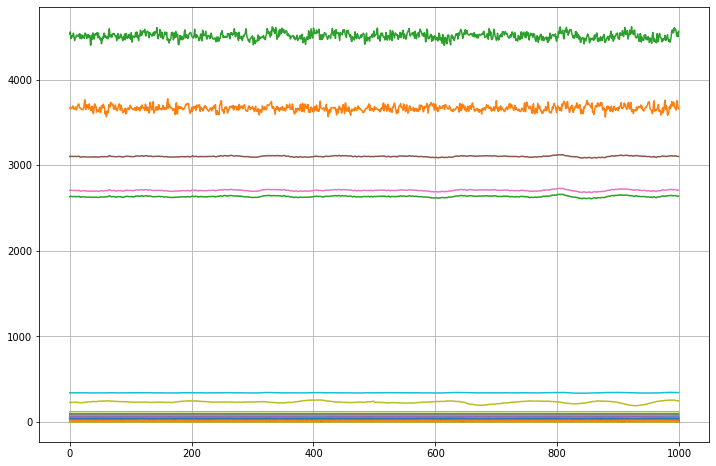

In [ ]:
plt.figure(figsize=(12, 8))
plt.grid()

for i in range(52):
    plt.plot(signal.iloc[:1000, i])
    
plt.show()

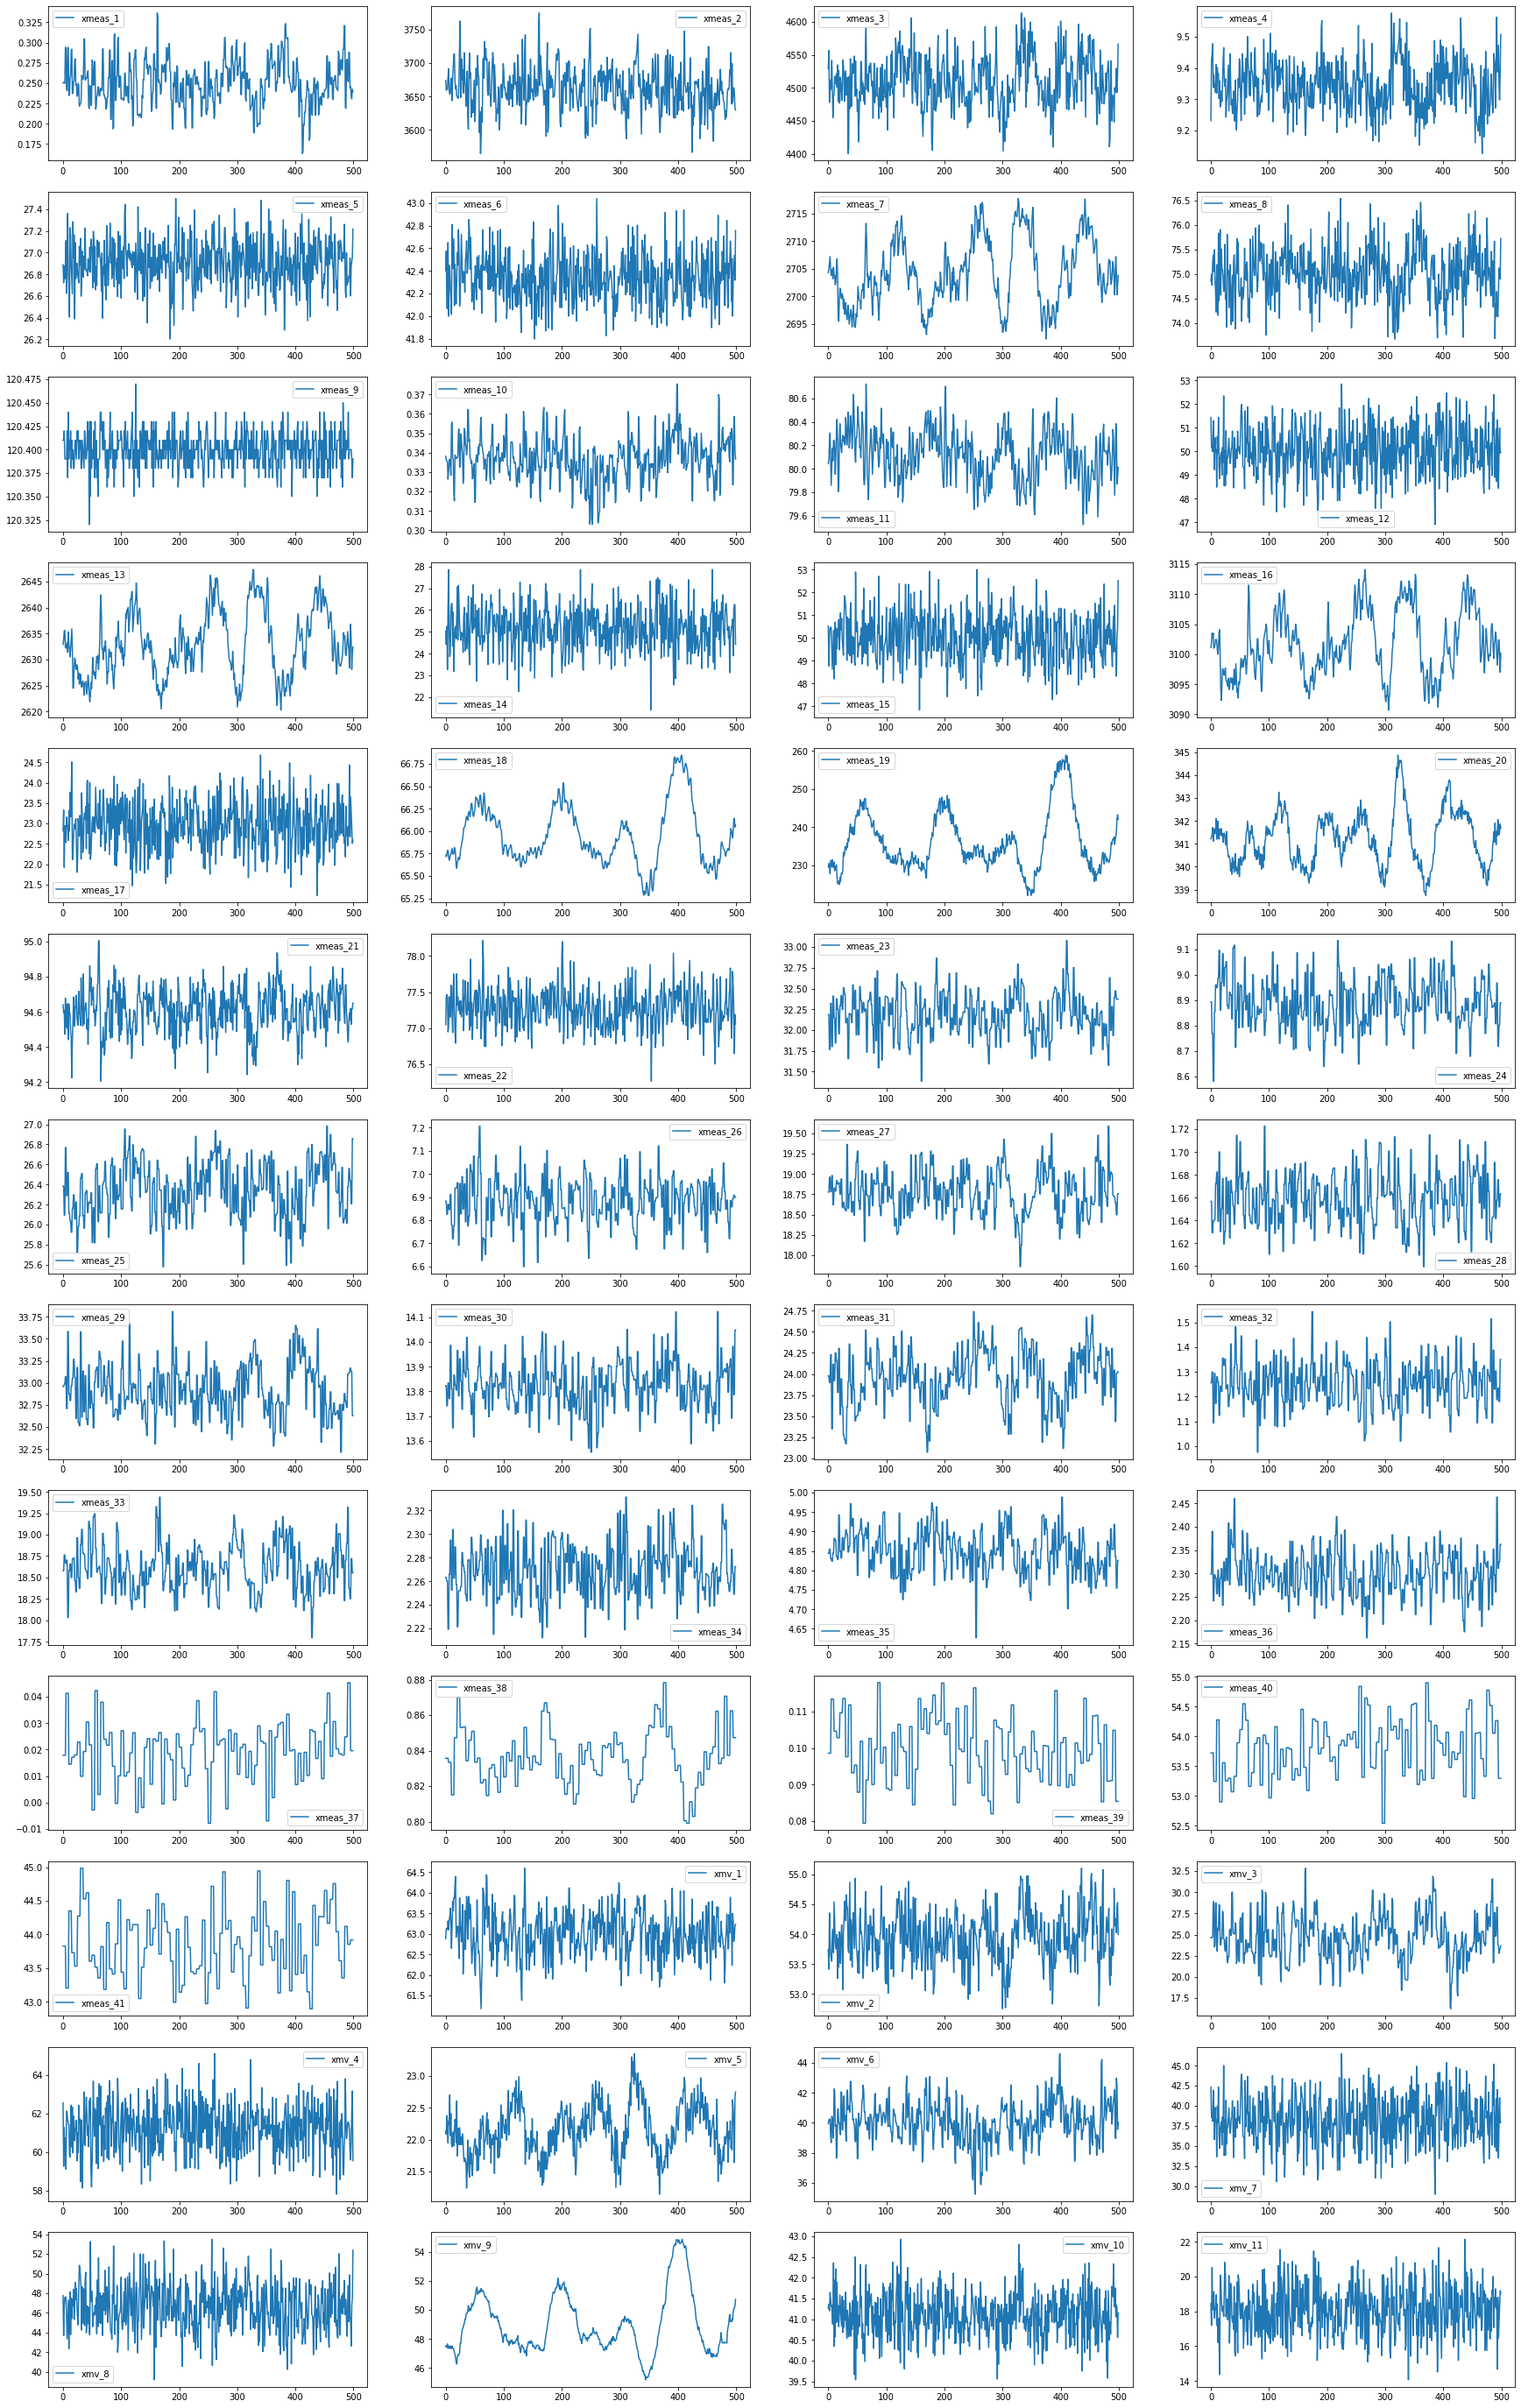

In [ ]:
fig, ax = plt.subplots(13,4,figsize=(30,50))
train_vis = tsdata[(tsdata.simulationRun==1)].iloc[:500, 3:]

for i in range(train_vis.shape[1]):
    train_vis.iloc[:,i].plot(ax=ax.ravel()[i]) 
    ax.ravel()[i].legend()

In [12]:
batch_size = 64
window = 64
lag = 1        

dataset = TSDataset(mm_train_signal, window, 1)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Первый батч потребуется для конфигурирования архитектур сетей энкодера / декодера
for batch in trainloader:
    break

batch = batch.to(device)

### Построение baseline на основе алгоритма LOF из пакета Scikit-learn

In [14]:
testdata = pd.read_csv('testdata.csv')

In [15]:
def faulty_set(fault, max_len):
    window = 64
    limit = (max_len // window) * window
    
    healthy_anomaly = []
    labels = []
    
    mm_healthy = mm_train_signal[:max_len]
    mm_faulty = minmax.fit_transform(testdata[testdata['faultNumber'] == fault].iloc[:, 4:])
    
    for i in range(max_len // 1000):
        healthy_fraction = mm_healthy[i * 500: (i + 1) * 500]
        healthy_anomaly.append(healthy_fraction)
        labels += [0] * len(healthy_fraction)

        faulty_fraction = mm_faulty[i * 500: (i + 1) * 500]
        healthy_anomaly.append(faulty_fraction)
        labels += [1] * len(faulty_fraction)
            
    return np.vstack(healthy_anomaly), labels

In [ ]:
clf = LocalOutlierFactor(novelty=True)
mm_healthy_signal = mm_train_signal[:25000]

clf.fit(mm_healthy_signal)

LocalOutlierFactor(novelty=True)

In [ ]:
lof_recalls = {}
lof_precision = {}

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 10000)
    test_scaled_signal = minmax.fit_transform(test_faulty)
    anomalies = clf.predict(test_scaled_signal)
    anomalies[anomalies == 1] = 0
    anomalies[anomalies == -1] = 1
    
    lof_recalls[fault] = recall_score(y_true, anomalies)
    lof_precision[fault] = precision_score(y_true, anomalies)

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
sns_lof_recall = pd.DataFrame(columns=['Recall', 'Faults','Classifier'])
sns_lof_recall['Recall'] = lof_recalls.values()
sns_lof_recall['Faults'] = list(range(1, 21))
sns_lof_recall['Classifier'] = ['LOF'] * 20

sns_lof_precision = pd.DataFrame(columns=['Precision', 'Faults','Classifier'])
sns_lof_precision['Precision'] = lof_precision.values()
sns_lof_precision['Faults'] = list(range(1, 21))
sns_lof_precision['Classifier'] = ['LOF'] * 20

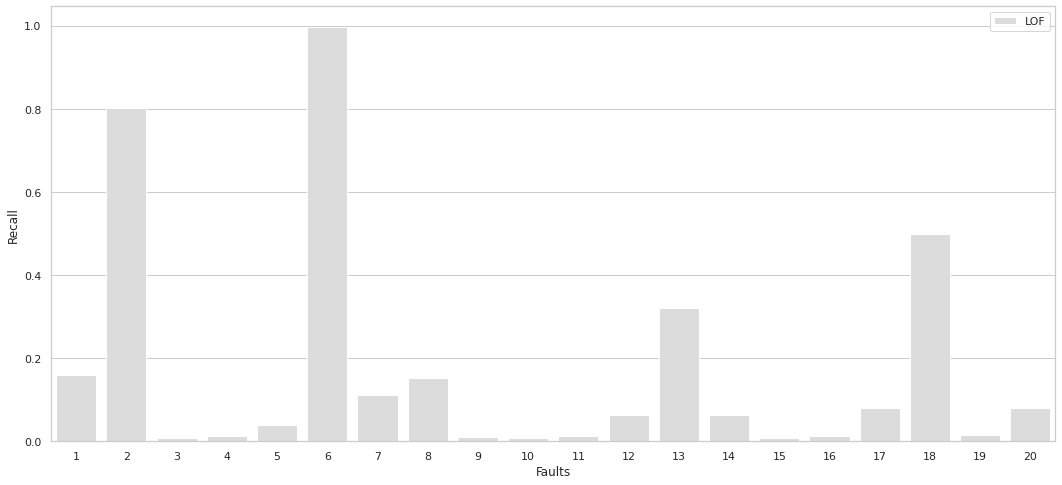

In [ ]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 8))

#sns.set_color_codes("hls")
sns.color_palette('husl', 5)
sns.barplot(x='Faults', 
            y='Recall',
            hue='Classifier', data=sns_lof_recall, palette='coolwarm', saturation=1., orient='v')

# Add a legend and informative axis label
ax.legend(ncol=1, loc="upper right", frameon=True)

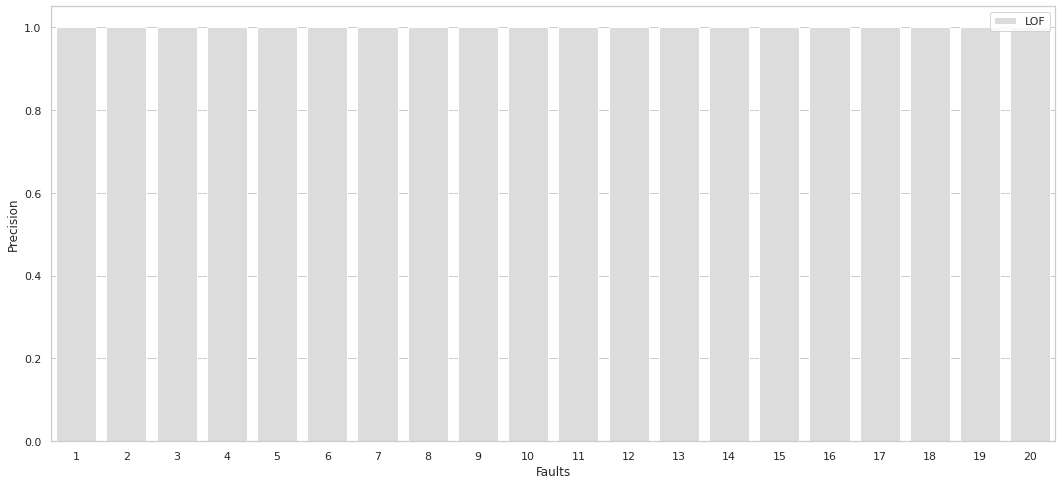

In [ ]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 8))

#sns.set_color_codes("hls")
sns.color_palette('husl', 5)
sns.barplot(x='Faults', 
            y='Precision',
            hue='Classifier', data=sns_lof_precision, palette='coolwarm', saturation=1., orient='v')

# Add a legend and informative axis label
ax.legend(ncol=1, loc="upper right", frameon=True)

In [ ]:
mean_metrics = pd.DataFrame(index=['Mean recall', 'Mean precision'], columns=['LOF', 'PCA', 'MLP', 'TCN'])
mean_metrics['LOF'] = [sns_lof_recall.Recall.mean(), sns_lof_precision.Precision.mean()]
mean_metrics

,LOF,PCA,MLP,TCN
Mean recall,0.17266,NaN,NaN,NaN
Mean precision,1.00000,NaN,NaN,NaN


### Построение baseline на основе метода главных компонент


  0%|          | 0/20 [00:00<?, ?it/s]

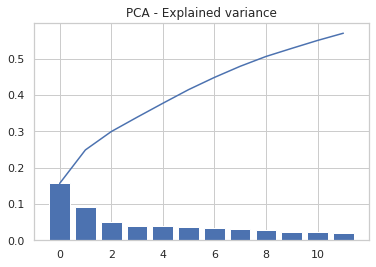

In [ ]:
pca_model = BaselinePCA()

mm_healthy_signal = mm_train_signal[:100000]
spe_train = pca_model.train(mm_healthy_signal, plot = True)
pca_upper_bound = np.percentile(spe_train, 99.99)

pca_recalls = {}
pca_precisions = {}

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 10000)
    test_df = pd.DataFrame(test_faulty, columns=signal.columns)
    spe_test = pca_model.test(test_df)
    
    spe_test[spe_test < pca_upper_bound] = 0
    spe_test[spe_test >= pca_upper_bound] = 1
    
    recall = recall_score(y_true, spe_test)
    precision = precision_score(y_true, spe_test)
    
    pca_recalls[fault] = recall
    pca_precisions[fault] = precision

In [ ]:
sns_pca_recall = pd.DataFrame(columns=['Recall', 'Faults','Classifier'])
sns_pca_recall['Recall'] = pca_recalls.values()
sns_pca_recall['Faults'] = list(range(1, 21))
sns_pca_recall['Classifier'] = ['PCA'] * 20

sns_pca_precision = pd.DataFrame(columns=['Precision', 'Faults','Classifier'])
sns_pca_precision['Precision'] = pca_precisions.values()
sns_pca_precision['Faults'] = list(range(1, 21))
sns_pca_precision['Classifier'] = ['PCA'] * 20

In [ ]:
sns_recall = pd.concat([sns_lof_recall, sns_pca_recall], axis=0)
sns_precision = pd.concat([sns_lof_precision, sns_pca_precision], axis=0)

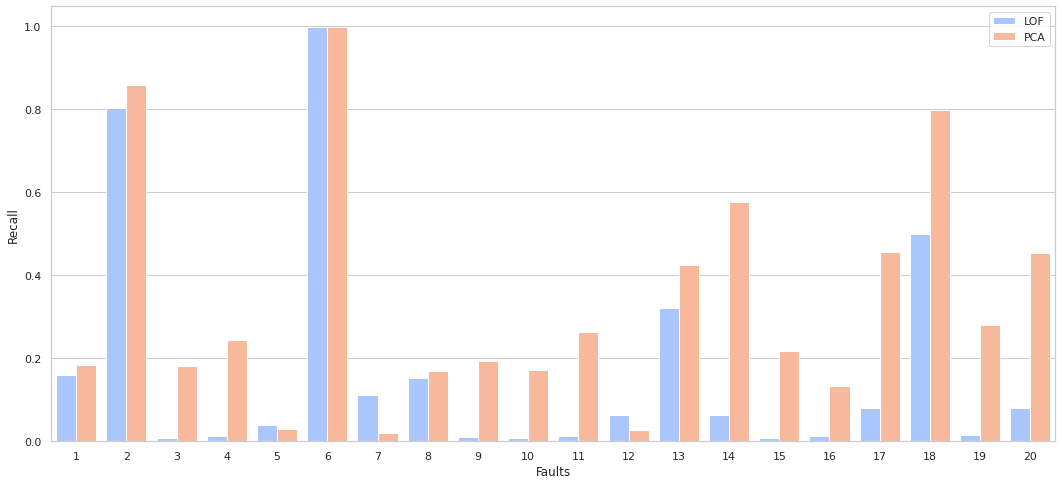

In [ ]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 8))

#sns.set_color_codes("hls")
sns.color_palette('husl', 5)
sns.barplot(x='Faults', 
            y='Recall',
            hue='Classifier', data=sns_recall, palette='coolwarm', saturation=1., orient='v')

# Add a legend and informative axis label
ax.legend(ncol=1, loc="upper right", frameon=True)

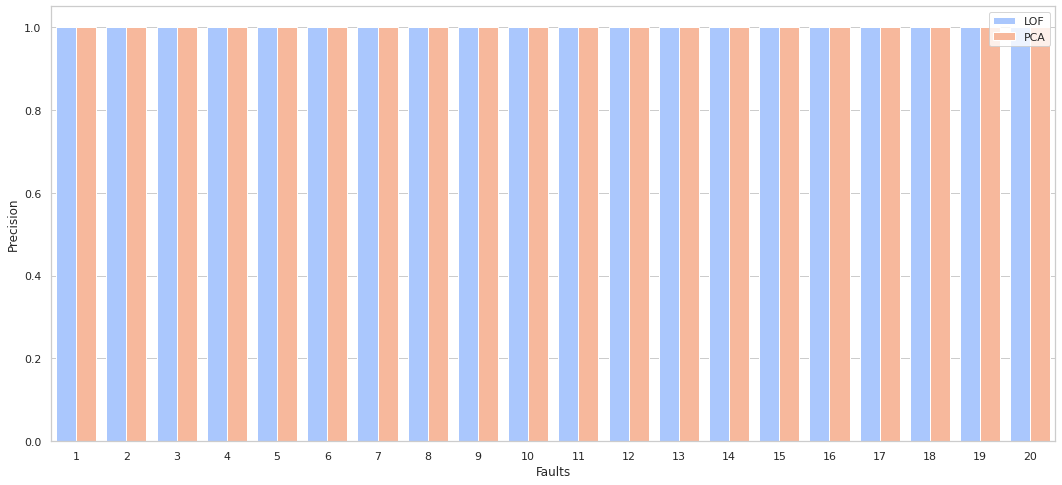

In [ ]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 8))

#sns.set_color_codes("hls")
sns.color_palette('husl', 5)
sns.barplot(x='Faults', 
            y='Precision',
            hue='Classifier', data=sns_precision, palette='coolwarm', saturation=1., orient='v')

# Add a legend and informative axis label
ax.legend(ncol=1, loc="upper right", frameon=True)

In [ ]:
mean_metrics['PCA'] = [sns_pca_recall.Recall.mean(), sns_pca_precision.Precision.mean()]
mean_metrics

,LOF,PCA,MLP,TCN
Mean recall,0.17266,0.3337,NaN,NaN
Mean precision,1.00000,1.0000,NaN,NaN


### Обучение вариационного автокодировщика на данных без аномалий

#### (настройка гиперпараметров автокодировщика производится по эмбеддингам линейной модели)

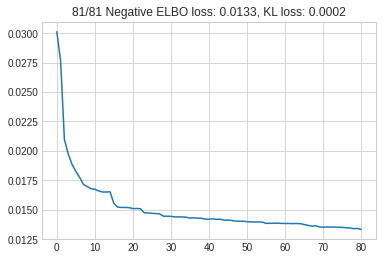

In [ ]:
kldivs = []
mses = []
loss_vals = []
name = 'full_mlp'
learning_rate = 1e-4
n_epochs = 81
latent_dim = 16
beta = 0.05

basic_emb = Basic_net(batch).to(device)
embedded = basic_emb(batch.to(device))
encoder = LinearEncoder(embedded, latent_dim=latent_dim)
encoder = encoder.to(device)
decoder = Decoder(batch.shape, latent_dim).to(device)
mlpvae = VAE(encoder, decoder)
mlpvae = mlpvae.to(device)
criterion = nn.MSELoss()
opt = Adam(mlpvae.parameters(), lr=learning_rate)
mse = MSELoss()

for i in tqdm(range(n_epochs)):
    for b_n, batch in enumerate(trainloader): 
        batch = batch.to(device)       
        opt.zero_grad()
        
        logits, mu, logvar = mlpvae(batch)

        reconstruction_loss = mse(logits, batch)

        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - 
                                   logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2]) * beta
        loss = reconstruction_loss + kl_loss
        
        loss.sum().backward()
        opt.step()

    mses.append(reconstruction_loss)
    kldivs.append(kl_loss)
    loss_vals.append(loss.item())

    plt.plot(loss_vals[-100:])
    plt.title('{}/{} Negative ELBO loss: {:.4f}, KL loss: {:.4f}'.format(i+1, n_epochs, loss_vals[-1], kl_loss))
    plt.show();
    clear_output(wait=True)

    #if i % 20 == 0 and i > 0:
    torch.save(mlpvae.state_dict(), name + '_e' + str(i) + '_lr' + str(learning_rate) + 
               '_b' + str(batch.shape[0]) + '_beta' + str(beta) + '_lat' + str(latent_dim) + '.pkl')

Text(0.5, 0, 'epochs')

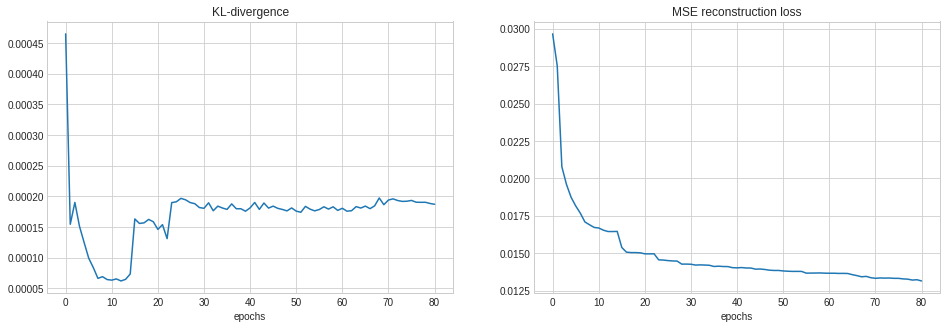

In [ ]:
plt.figure(figsize=(16, 5))
plt.style.use('seaborn-whitegrid')

plt.subplot(1, 2, 1)
plt.title("KL-divergence")
plt.xlabel("epochs")
plt.plot(kldivs)

plt.subplot(1, 2, 2)
plt.plot(mses)
plt.title("MSE reconstruction loss")
plt.xlabel("epochs")

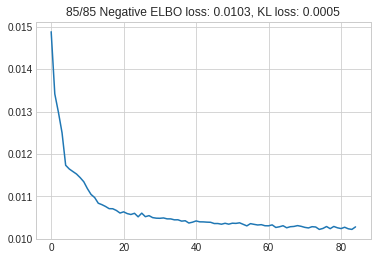

In [37]:
kldivs = []
mses = []
loss_vals = []
name = 'full_tcn'
learning_rate = 3e-5
n_epochs = 85
latent_dim = 16
beta = 0.05

encoder = TCNEncoder(batch, latent_dim=latent_dim)
decoder = TCNDecoder(batch, latent_dim=latent_dim)
tcnvae = VAE(encoder, decoder)
tcnvae = tcnvae.to(device)
criterion = nn.MSELoss()
opt = Adam(tcnvae.parameters(), lr=learning_rate)
mse = MSELoss()


for i in tqdm(range(n_epochs)):
    for b_n, batch in enumerate(trainloader):
        batch = batch.to(device)       
        opt.zero_grad()
        
        logits, mu, logvar = tcnvae(batch)

        reconstruction_loss = mse(logits, batch)

        kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                   logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2])
        loss = reconstruction_loss + kl_loss
        
        loss.sum().backward()
        opt.step()

    mses.append(reconstruction_loss)
    kldivs.append(kl_loss)
    loss_vals.append(loss.item())

    plt.plot(loss_vals[-100:])
    plt.title('{}/{} Negative ELBO loss: {:.4f}, KL loss: {:.4f}'.format(i+1, n_epochs, loss_vals[-1], kl_loss))
    plt.show();
    clear_output(wait=True)

torch.save(tcnvae.state_dict(), name + '_e' + str(i) + '_lr' + str(learning_rate) + 
            '_b' + str(batch_size) + '_beta' + str(beta) + '_lat' + str(latent_dim) + '.pkl')

#### Построение графиков reconstruction error и KL-divergence

Text(0.5, 0, 'epochs')

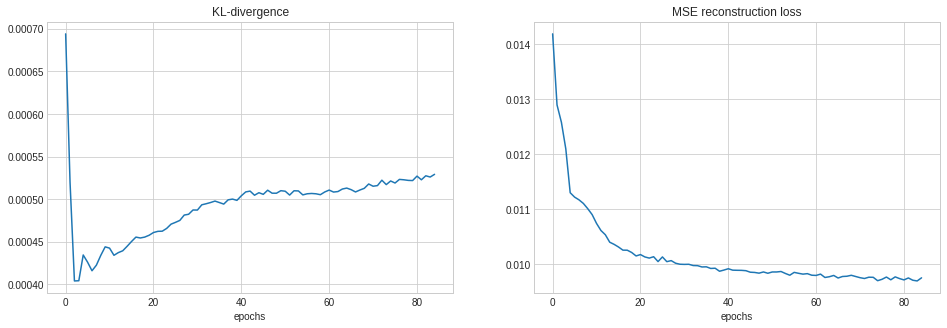

In [38]:
plt.figure(figsize=(16, 5))
plt.style.use('seaborn-whitegrid')

plt.subplot(1, 2, 1)
plt.title("KL-divergence")
plt.xlabel("epochs")
plt.plot(kldivs)

plt.subplot(1, 2, 2)
plt.plot(mses)
plt.title("MSE reconstruction loss")
plt.xlabel("epochs")


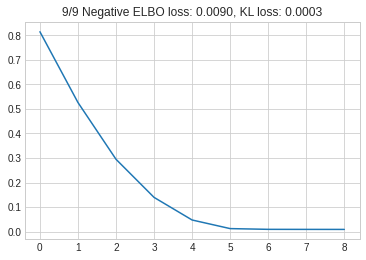

In [81]:
kldivs = []
mses = []
loss_vals = []
name = 'full_trans'
learning_rate = 3e-5
n_epochs = 9
latent_dim = 16
beta = 0.5

encoder = TransformEncoder(batch, latent_dim=latent_dim)
decoder = TransformDecoder(batch, latent_dim=latent_dim)
tvae = TVAE(encoder, decoder)
tvae = tvae.to(device)
criterion = nn.MSELoss()
opt = Adam(tvae.parameters(), lr=learning_rate)
mse = MSELoss()


for i in tqdm(range(n_epochs)):
    for b_n, batch in enumerate(trainloader):
        batch = batch.to(device)       
        opt.zero_grad()
        
        logits, mu, logvar = tvae(batch)

        reconstruction_loss = mse(logits, batch)

        kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                   logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2])
        loss = reconstruction_loss + kl_loss
        
        loss.sum().backward()
        opt.step()

    mses.append(reconstruction_loss)
    kldivs.append(kl_loss)
    loss_vals.append(loss.item())

    plt.plot(loss_vals[-100:])
    plt.title('{}/{} Negative ELBO loss: {:.4f}, KL loss: {:.4f}'.format(i+1, n_epochs, loss_vals[-1], kl_loss))
    plt.show();
    clear_output(wait=True)

torch.save(tvae.state_dict(), name + '_e' + str(i) + '_lr' + str(learning_rate) + 
            '_b' + str(batch_size) + '_beta' + str(beta) + '_lat' + str(latent_dim) + '.pkl')

Text(0.5, 0, 'epochs')

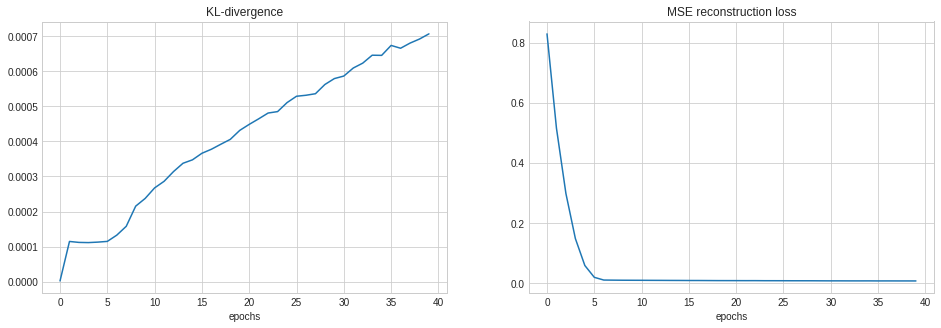

In [20]:
plt.figure(figsize=(16, 5))
plt.style.use('seaborn-whitegrid')

plt.subplot(1, 2, 1)
plt.title("KL-divergence")
plt.xlabel("epochs")
plt.plot(kldivs)

plt.subplot(1, 2, 2)
plt.plot(mses)
plt.title("MSE reconstruction loss")
plt.xlabel("epochs")

### Выявление аномалий через вычисление ошибки реконструкции сигнала

###MLP

In [ ]:
# Per sample losses distribution MLP
beta = 0.05
window = 64
eval_losses = []
row_wise_mse = nn.MSELoss(reduction='none')

mlpvae.eval()

for start in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[start * window: start * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch, mu, logvar = mlpvae(batch)
        
    mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
    kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                   logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2])
    losses = mse + kl_loss
    eval_losses = eval_losses + losses.tolist()

  0%|          | 0/3906 [00:00<?, ?it/s]

In [ ]:
upper_bound = np.percentile(np.stack(eval_losses), 99.99)
upper_bound

0.05346489848345312

In [ ]:
lower_bound = np.percentile(np.stack(eval_losses), 0.5)
lower_bound

0.007002618783153594

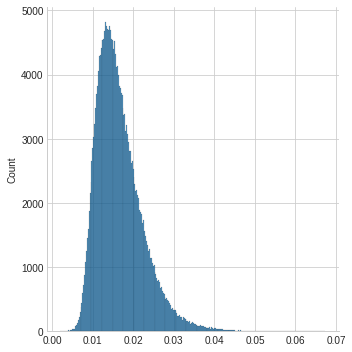

In [ ]:
sns.displot(np.stack(eval_losses))

In [ ]:
test_recall = []
test_precision = []
window = 64
mus = defaultdict(list)
row_wise_mse = nn.MSELoss(reduction='none')

mlpvae.eval()

iterations = 5000 // window

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 5000)
    per_fault_loss = np.array([])

    for k in range(iterations):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch, mu, logvar = mlpvae(batch)
            mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
            kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                              logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2]) 
            loss = mse + kl_loss
            per_fault_loss = np.append(per_fault_loss, loss.cpu().numpy())
            if k < 100:
                mus[fault].append(mu.cpu().numpy().tolist())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(y_true[: iterations * window], per_fault_loss))
    test_precision.append(precision_score(y_true[: iterations * window], per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,0.060995,0.926829
1,0.128411,0.993789
2,0.009631,1.000000
3,0.008026,1.000000
4,0.019262,0.960000
5,0.918539,0.999563
6,0.062199,0.917160
7,0.068218,1.000000
8,0.011637,1.000000
9,0.011236,1.000000


In [ ]:
sns_mlp_recall = pd.DataFrame(columns=['Recall', 'Faults','Classifier'])
sns_mlp_recall['Recall'] = metrics_df.Recall
sns_mlp_recall['Faults'] = list(range(1, 21))
sns_mlp_recall['Classifier'] = ['MLP'] * 20

sns_mlp_precision = pd.DataFrame(columns=['Precision', 'Faults','Classifier'])
sns_mlp_precision['Precision'] = metrics_df.Precision
sns_mlp_precision['Faults'] = list(range(1, 21))
sns_mlp_precision['Classifier'] = ['MLP'] * 20

In [ ]:
sns_recall = pd.concat([sns_recall, sns_mlp_recall], axis=0)
sns_precision = pd.concat([sns_precision, sns_mlp_precision], axis=0)

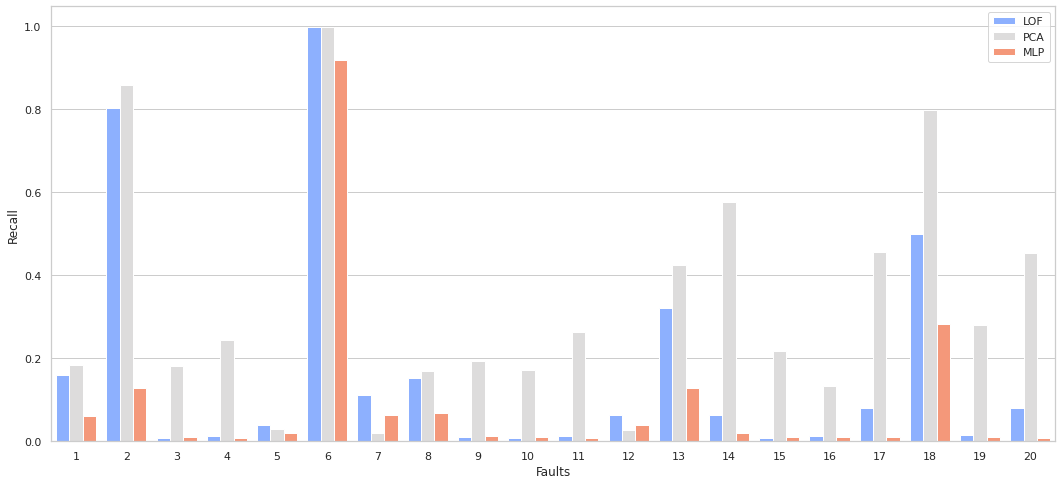

In [ ]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 8))

#sns.set_color_codes("hls")
sns.color_palette('husl', 5)
sns.barplot(x='Faults', 
            y='Recall',
            hue='Classifier', data=sns_recall, palette='coolwarm', saturation=1., orient='v')

# Add a legend and informative axis label
ax.legend(ncol=1, loc="upper right", frameon=True)

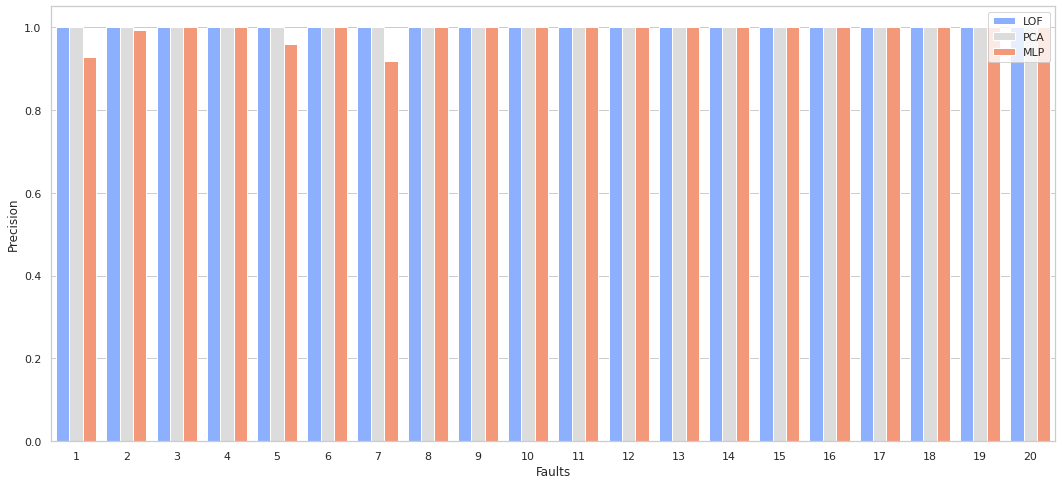

In [ ]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 8))

#sns.set_color_codes("hls")
sns.color_palette('husl', 5)
sns.barplot(x='Faults', 
            y='Precision',
            hue='Classifier', data=sns_precision, palette='coolwarm', saturation=1., orient='v')

# Add a legend and informative axis label
ax.legend(ncol=1, loc="upper right", frameon=True)

In [ ]:
mean_metrics['MLP'] = [sns_mlp_recall.Recall.mean(), sns_mlp_precision.Precision.mean()]
mean_metrics

,LOF,PCA,MLP,TCN
Mean recall,0.17266,0.3337,0.091031,NaN
Mean precision,1.00000,1.0000,0.989867,NaN


###TCN

In [39]:
# Per sample losses distribution TCN
beta = 0.05
window = 64
eval_losses = []
row_wise_mse = nn.MSELoss(reduction='none')

tcnvae.eval()

for start in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[start * window: start * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch, mu, logvar = tcnvae(batch)
        
    mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
    kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                   logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2])
    losses = mse + kl_loss
    eval_losses = eval_losses + losses.tolist()

  0%|          | 0/3906 [00:00<?, ?it/s]

In [40]:
upper_bound = np.percentile(np.stack(eval_losses), 99.99)
upper_bound

0.03211087918169613

In [41]:
lower_bound = np.percentile(np.stack(eval_losses), 0.5)
lower_bound

0.011090744114480914

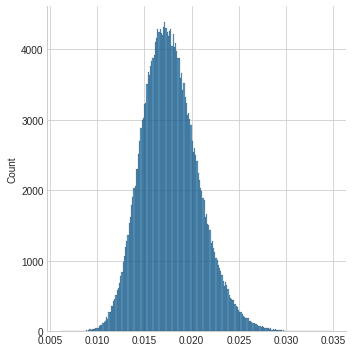

In [42]:
sns.displot(np.stack(eval_losses))

In [43]:
test_recall = []
test_precision = []
window = 64
mus = defaultdict(list)
row_wise_mse = nn.MSELoss(reduction='none')

iterations = 5000 // window

tcnvae.eval()

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 5000)
    per_fault_loss = np.array([])

    for k in range(iterations):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch, mu, logvar = tcnvae(batch)
            mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
            kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                              logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2]) 
            loss = mse + kl_loss
            per_fault_loss = np.append(per_fault_loss, loss.cpu().numpy())
            if k < 100:
                mus[fault].append(mu.cpu().numpy().tolist())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(y_true[: iterations * window], per_fault_loss))
    test_precision.append(precision_score(y_true[: iterations * window], per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,0.353933,0.967105
1,0.950642,0.994125
2,0.233146,0.996569
3,0.243178,0.995074
4,0.219101,0.971530
5,0.999599,0.997597
6,0.294543,0.895122
7,0.306581,0.992208
8,0.245185,0.995114
9,0.293339,0.995913


In [44]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.38870385232744786, 0.9886064462894328)

In [ ]:
sns_tcn_recall = pd.DataFrame(columns=['Recall', 'Faults','Classifier'])
sns_tcn_recall['Recall'] = metrics_df.Recall
sns_tcn_recall['Faults'] = list(range(1, 21))
sns_tcn_recall['Classifier'] = ['TCN'] * 20

sns_tcn_precision = pd.DataFrame(columns=['Precision', 'Faults','Classifier'])
sns_tcn_precision['Precision'] = metrics_df.Precision
sns_tcn_precision['Faults'] = list(range(1, 21))
sns_tcn_precision['Classifier'] = ['TCN'] * 20

In [ ]:
sns_recall = pd.concat([sns_recall, sns_tcn_recall], axis=0)
sns_precision = pd.concat([sns_precision, sns_tcn_precision], axis=0)

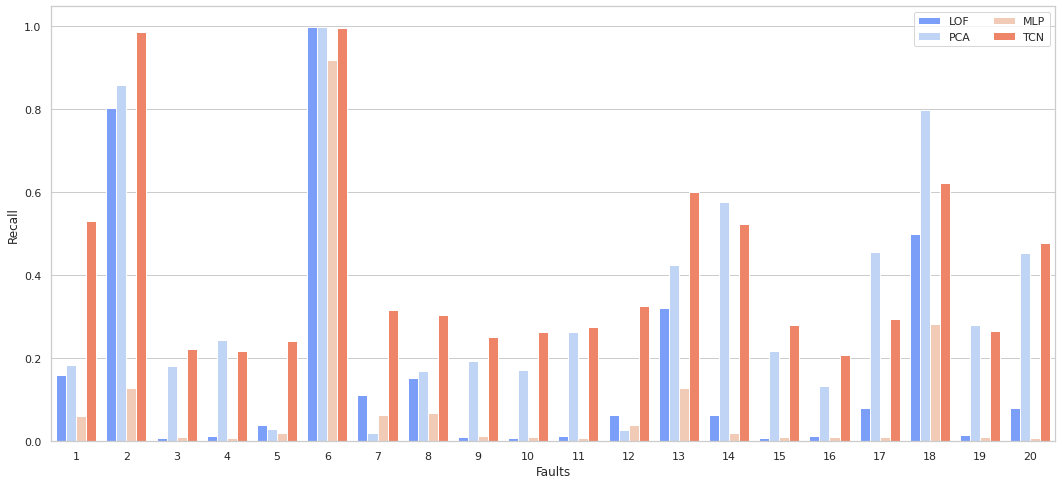

In [ ]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 8))

#sns.set_color_codes("hls")
sns.color_palette('husl', 5)
sns.barplot(x='Faults', 
            y='Recall',
            hue='Classifier', data=sns_recall, palette='coolwarm', saturation=1., orient='v')

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)

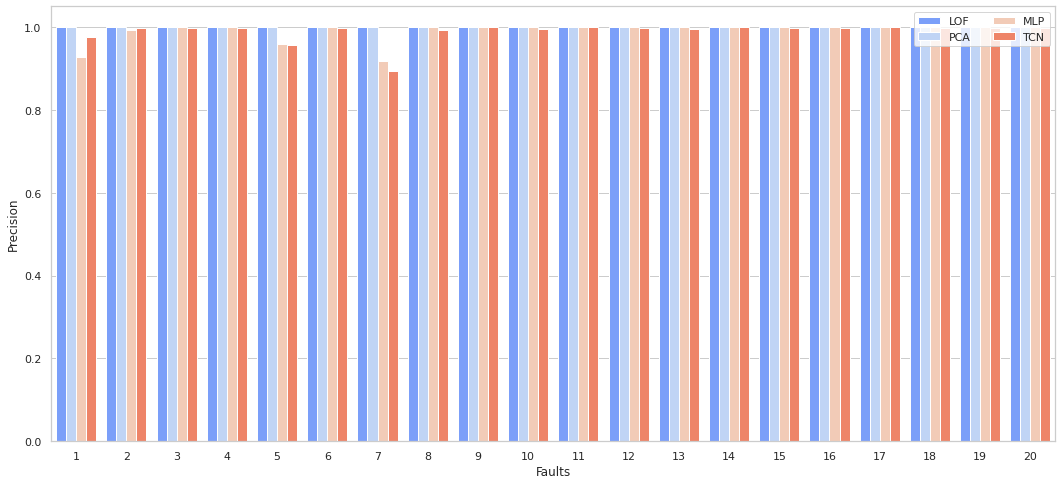

In [ ]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18, 8))

#sns.set_color_codes("hls")
sns.color_palette('husl', 5)
sns.barplot(x='Faults', 
            y='Precision',
            hue='Classifier', data=sns_precision, palette='coolwarm', saturation=1., orient='v')

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)

In [ ]:
mean_metrics['TCN'] = [sns_tcn_recall.Recall.mean(), sns_tcn_precision.Precision.mean()]
mean_metrics

,LOF,PCA,MLP,TCN
Mean recall,0.17266,0.3337,0.091031,0.409751
Mean precision,1.00000,1.0000,0.989867,0.989655


**Transformer**

In [82]:
# Per sample losses distribution TCN
beta = 0.5
window = 64
eval_losses = []
row_wise_mse = nn.MSELoss(reduction='none')

tvae.eval()

for start in tqdm(range(len(mm_train_signal) // window)):
    
    batch = torch.tensor(mm_train_signal[start * window: start * window + window, :], dtype=torch.float).unsqueeze(0).to(device)
        
    with torch.no_grad():
        reconstructed_batch, mu, logvar = tvae(batch)
        
    mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
    kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                   logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2])
    losses = mse + kl_loss
    eval_losses = eval_losses + losses.tolist()

  0%|          | 0/3906 [00:00<?, ?it/s]

In [83]:
upper_bound = np.percentile(np.stack(eval_losses), 99.99)
upper_bound

0.01898095082100401

In [84]:
lower_bound = np.percentile(np.stack(eval_losses), 0.5)
lower_bound

0.004547412693500519

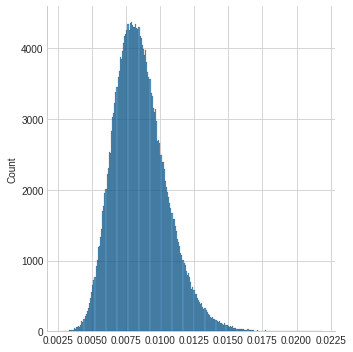

In [85]:
sns.displot(np.stack(eval_losses))

In [94]:
test_recall = []
test_precision = []
window = 64
mus = defaultdict(list)
row_wise_mse = nn.MSELoss(reduction='none')
upper_bound = 0.0155

iterations = 5000 // window

tvae.eval()

for fault in tqdm(np.unique(testdata.faultNumber)):
    test_faulty, y_true = faulty_set(fault, 5000)
    per_fault_loss = np.array([])

    for k in range(iterations):

        batch = torch.tensor(test_faulty[k * window : k * window + window], dtype=torch.float).unsqueeze(0).to(device)

        with torch.no_grad():
            reconstructed_batch, mu, logvar = tvae(batch)
            mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
            kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                              logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2]) 
            loss = mse + kl_loss
            per_fault_loss = np.append(per_fault_loss, loss.cpu().numpy())
            if k < 100:
                mus[fault].append(mu.cpu().numpy().tolist())

    per_fault_loss[per_fault_loss < upper_bound] = 0
    per_fault_loss[per_fault_loss >= upper_bound] = 1

    test_recall.append(recall_score(y_true[: iterations * window], per_fault_loss))
    test_precision.append(precision_score(y_true[: iterations * window], per_fault_loss))
    
metrics_df = pd.DataFrame.from_dict({'Recall': test_recall, 'Precision': test_precision})
metrics_df

  0%|          | 0/20 [00:00<?, ?it/s]

,Recall,Precision
0,0.262440,0.984940
1,0.721108,0.995017
2,0.271669,0.986880
3,0.293740,0.987854
4,0.143660,0.975477
5,1.000000,0.996401
6,0.189406,0.981289
7,0.232343,0.984694
8,0.290931,0.987738
9,0.313804,0.989873


In [95]:
metrics_df.Recall.mean(), metrics_df.Precision.mean()

(0.4134430176565008, 0.9888375740757377)

### Заключение

В работе исследовалась возможность обнаружения аномалий нейросетевыми методами в unsupervised схеме с использованием вариационного автокодировщика. В качестве структурных блоков кодировщика и декодировщика использовались полносвязная сеть (MLP - Nulti-Layer Perceptron) и TCN (Temporal Convolution Network) против результатов baseline-алгоритмов LOF (Local Outlier Factor) и PCA (Principal Component Analysis). 

PCA, MLP и TCN детектируют аномалии по превышению ошибкой некоего порога, выбранного для всех алгоритмов в виде 99.99% перцентиля. Наилучший результат по метрике Recall продемонстрировала модель на основе TCN. Однако, на ошибках №№ 4, 14, 17, 18 и 19 метод РСА оказался лучше остальных. На ошибках 1, 5 и 12 метод на основе TCN в несколько раз превысил Recall других методов. 

Так как верхний порог ошибки везде выбирался одинаковым и очень высоким, то метрики Precision везде оказались близкими к или равными 1. 
Во всех случаях детектирования аномалий методами LOF и РСА метрика Precision оказалась строго равной 1, т.е. False Positives полностью отсутствуют. 

Обучение нейросетевых моделей производилось в схеме Beta-VAE при очень низких значениях Beta = 0.05. Модели со значениеми Beta ниже 0.05 не исследовались и потенциально могут показать результат лучше представленного. Некоторые работы описывают обучение Beta-VAE моделей с коэффициентов Beta, меняющимся пило-образно в некотором диапазоне, что может существенно улучшить результаты моделей на стадии inference. В данной работе такое исследование не проводилось. 

In [36]:
try:
    from fddbenchmark import FDDDataset, FDDDataloader, FDDEvaluator
except:
    !git clone https://github.com/airi-industrial-ai/fddbenchmark
    from fddbenchmark import FDDDataset, FDDDataloader, FDDEvaluator

Cloning into 'fddbenchmark'...
remote: Enumerating objects: 53, done.
remote: Total 53 (delta 0), reused 0 (delta 0), pack-reused 53
Unpacking objects: 100% (53/53), done.


In [37]:
small_tep = FDDDataset(name='small_tep', splitting_type='supervised')

minmax = MinMaxScaler()

small_tep.df = pd.DataFrame(data=minmax.fit_transform(small_tep.df), index=small_tep.df.index)

test_dl = FDDDataloader(
    dataframe=small_tep.df[small_tep.test_mask],
    labels=small_tep.labels[small_tep.test_mask],
    window_size=64, 
    step_size=64, 
    minibatch_training=True,
    batch_size=1,
)

Downloading: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


In [108]:
preds = []
labels = []
upper_bound = 0.021 #np.percentile(eval_losses, 55)

tvae.eval()

for test_ts, test_index, test_label in tqdm(test_dl):
    batch = torch.tensor(test_ts).to(torch.float).to(device)
    with torch.no_grad():
        reconstructed_batch, mu, sigma = tvae(batch)
        
    mse = row_wise_mse(reconstructed_batch, batch).mean(2).squeeze()
    kl_loss = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - 
                                          logvar.exp(), -1).mean() / (batch.shape[0] * batch.shape[1] * batch.shape[2]) 
    loss = mse + kl_loss
    
    pred = 1 if torch.any(loss > upper_bound) else 0
    
    preds.append(pd.Series(pred, index=test_index))
    labels.append(test_label)
    
pred = pd.concat(preds)
test_label = pd.concat(labels)

  0%|          | 0/1470 [00:00<?, ?it/s]

In [109]:
evaluator = FDDEvaluator(
    splitting_type=small_tep.splitting_type, 
    step_size=test_dl.step_size
)

evaluator.print_metrics(test_label, pred)

Detection metrics
-----------------
True Positive Rate (TPR): 0.5158
False Positive Rate (FPR): 0.1185
Average Detection Delay (ADD): 138.11

Diagnosis metrics
-----------------
Correct Diagnosis Rate (CDR):
    Fault 01: 1.0000
    Fault 02: 0.0000
    Fault 03: 0.0000
    Fault 04: 0.0000
    Fault 05: 0.0000
    Fault 06: 0.0000
    Fault 07: 0.0000
    Fault 08: 0.0000
    Fault 09: 0.0000
    Fault 10: 0.0000
    Fault 11: 0.0000
    Fault 12: 0.0000
    Fault 13: 0.0000
    Fault 14: 0.0000
    Fault 15: 0.0000
    Fault 16: 0.0000
    Fault 17: 0.0000
    Fault 18: 0.0000
    Fault 19: 0.0000
    Fault 20: 0.0000
Total Correct Diagnosis Rate (Total CDR): 0.0468
Misdiagnosis Rate (MDR): 0.9532


In [50]:
upper_bound

0.011431843042373657